# Predicting the sales price of bulldozers using Machine Learning
In this notebook, we're going to go through an example machine learning project with the goal of predicting the sale price of bulldozers sold at auctions.

## 1. Problem Definition
> How well can we predict the future sale price of a bulldozer given its characteristics and previous examples of how much similar bulldozers have been sold for?

## 2. Data
The data is downloaded from [Kaggle's Bulldozer Price Prediction Competition](https://www.kaggle.com/competitions/bluebook-for-bulldozers/data) and consists of three main datasets:
* **Train.csv** is the training set, which contains data through the end of 2011.
* **Valid.csv** is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
* **Test.csv** is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.

## 3. Evaluation
The evaluation metric for this competition is the RMSLE (root mean squared log error) between the actual and predicted auction prices.
More information on the evaluation of this project can be found [here](https://www.kaggle.com/competitions/bluebook-for-bulldozers/overview/evaluation).

**Note:** The goal for most regression evaluation metrics is to minimize the error. For example, our goal for this project will be to build a model which minimizes RMSLE.

## 4. Features
Kaggle provides a data dictionary detailing all the features of the dataset [here](https://www.kaggle.com/competitions/bluebook-for-bulldozers/data?select=Data+Dictionary.xlsx).

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn

In [3]:
# Import training and validation sets
df = pd.read_csv("data/TrainAndValid.csv", low_memory=False)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

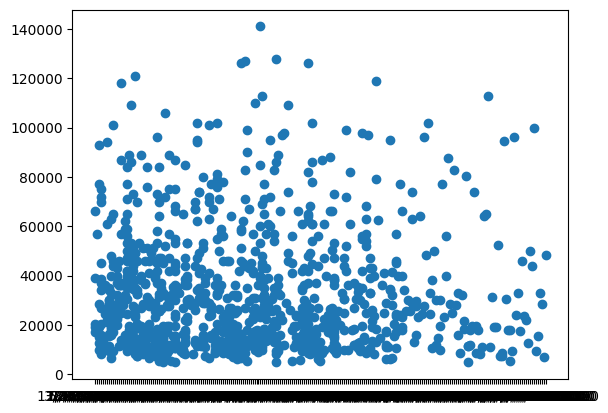

In [5]:
fig, ax = plt.subplots()
ax.scatter(df["saledate"][:1000], df["SalePrice"][:1000])

<Axes: ylabel='Frequency'>

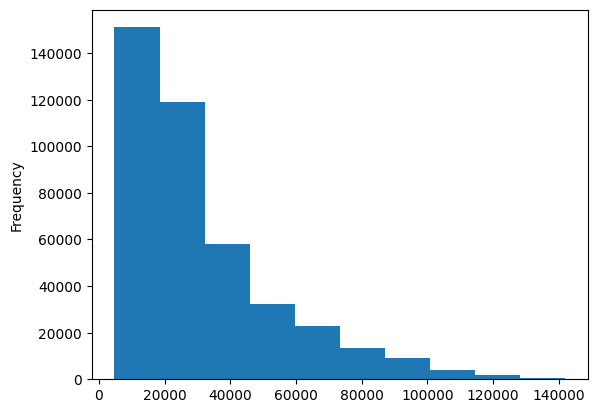

In [6]:
df.SalePrice.plot.hist()

### Parsing dates
when we work with time series data, we want to enrich the time & date component as much as possible. We can do that by telling pandas which of our columns has dates in it using the `parse_dates` parameter.

In [14]:
# Import data again but this time parse dates
df = pd.read_csv("data/TrainAndValid.csv", low_memory=False, parse_dates=["saledate"])
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


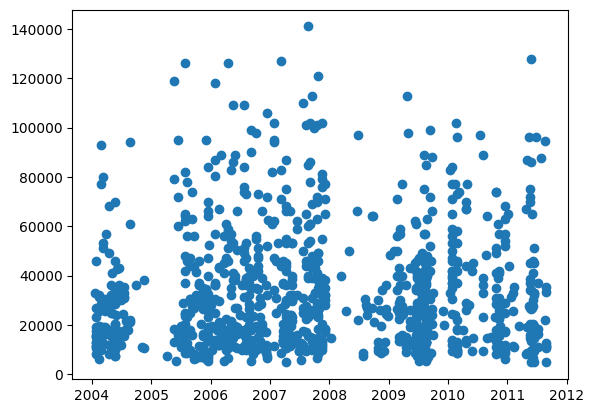

In [9]:
fig, ax = plt.subplots()
ax.scatter(df["saledate"][:1000], df["SalePrice"][:1000]);


### Sort dataframe by saledate
When working with time series data, it's a good idea to sort it by date.


In [16]:
# Sort DataFrame in date order
df.sort_values(by=["saledate"], inplace=True, ascending=True)
df.saledate.head(5)

205615   1989-01-17
233186   1989-01-31
142491   1989-01-31
115536   1989-01-31
92301    1989-01-31
Name: saledate, dtype: datetime64[ns]

### Make a copy of the original dataframe
we make a copy of the original dataframe so when we manipulate the data, we're still able to access the original data if we need it.

In [30]:
# Make a copy of the original DataFrame to perform edits on
df_tmp = df.copy()

### Add datetime parameters for `saledate` column
We can enrich the dataframe with additional datetime parameters by creating new columns from the `saledate` column.

In [31]:
df_tmp[:1].saledate.dt.year

205615    1989
Name: saledate, dtype: int32

In [32]:
df_tmp["saleYear"] = df_tmp.saledate.dt.year
df_tmp["saleMonth"] = df_tmp.saledate.dt.month
df_tmp["saleDay"] = df_tmp.saledate.dt.day
df_tmp["saleDayofweek"] = df_tmp.saledate.dt.dayofweek
df_tmp["saleDayofyear"] = df_tmp.saledate.dt.dayofyear

In [33]:
# Now we've enriched our DataFrame with date time features, we can remove `saledate`
df_tmp.drop("saledate", axis=1, inplace=True)

In [34]:
df_tmp.state.value_counts()

state
Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Montana            1336
Iowa               1336
Oklahoma           1326
Nebraska            866
West Virgi

## 5. Modelling
We're now going to start to do some model-driven EDA.

In [65]:
# Let's build a machine learning model
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_jobs=-1, random_state=42)
# model.fit(df_tmp.drop("SalePrice", axis=1), df_tmp["SalePrice"])
# Above line won't work because our data still contains strings (categorical data)

# Check for columns which contain strings
df_tmp.isna().sum()


SalesID                         0
SalePrice                       0
MachineID                       0
ModelID                         0
datasource                      0
                               ..
Backhoe_Mounting_is_missing     0
Blade_Type_is_missing           0
Travel_Controls_is_missing      0
Differential_Type_is_missing    0
Steering_Controls_is_missing    0
Length: 103, dtype: int64

### string to categories
One way we can turn all of our string values into numbers is by converting them into pandas categories.
We can check the datytypes compatible here: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dtypes.html


In [41]:
# FInd the columns which contain strings
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        df_tmp[label] = content.astype("category").cat.as_ordered()

In [45]:
df_tmp.isnull().sum()/len(df_tmp)

SalesID                     0.000000
SalePrice                   0.000000
MachineID                   0.000000
ModelID                     0.000000
datasource                  0.000000
auctioneerID                0.048791
YearMade                    0.000000
MachineHoursCurrentMeter    0.642586
UsageBand                   0.821492
fiModelDesc                 0.000000
fiBaseModel                 0.000000
fiSecondaryDesc             0.340993
fiModelSeries               0.857845
fiModelDescriptor           0.818715
ProductSize                 0.524851
fiProductClassDesc          0.000000
state                       0.000000
ProductGroup                0.000000
ProductGroupDesc            0.000000
Drive_System                0.740520
Enclosure                   0.000809
Forks                       0.520921
Pad_Type                    0.803498
Ride_Control                0.629928
Stick                       0.803498
Transmission                0.544444
Turbocharged                0.803498
B

What to do with missing values?
### Filling missing values
We could fill them with some values (like the mean, median, etc) or we could remove them altogether.

#### Filling numerical missing values first
One way to fill missing numerical values is to fill them with the median of the column.

In [48]:
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum() > 0:
            # Add a binary column which tells us whether the data was missing or not
            df_tmp[label + "_is_missing"] = pd.isnull(content)
            # Fill missing numeric values with median (median is more robust than mean to outliers)
            df_tmp[label] = content.fillna(content.median())

#### Filling categorical missing values next
For categorical variables, we can add a new category called "Missing" and fill all the missing values with that new category.

In [56]:
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum() > 0:
            print(f"Label {label} has {pd.isnull(content).sum()} missing values")

Label UsageBand has 339028 missing values
Label fiSecondaryDesc has 140727 missing values
Label fiModelSeries has 354031 missing values
Label fiModelDescriptor has 337882 missing values
Label ProductSize has 216605 missing values
Label Drive_System has 305611 missing values
Label Enclosure has 334 missing values
Label Forks has 214983 missing values
Label Pad_Type has 331602 missing values
Label Ride_Control has 259970 missing values
Label Stick has 331602 missing values
Label Transmission has 224691 missing values
Label Turbocharged has 331602 missing values
Label Blade_Extension has 386715 missing values
Label Blade_Width has 386715 missing values
Label Enclosure_Type has 386715 missing values
Label Engine_Horsepower has 386715 missing values
Label Hydraulics has 82565 missing values
Label Pushblock has 386715 missing values
Label Ripper has 305753 missing values
Label Scarifier has 386704 missing values
Label Tip_Control has 386715 missing values
Label Tire_Size has 315060 missing v

In [57]:
# Turn categorical variables into numbers and fill missing
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        # Add a binary column to indicate whether sample had missing value
        df_tmp[label + "_is_missing"] = pd.isnull(content)
        # Turn categories into numbers and add +1
        df_tmp[label] = pd.Categorical(content).codes + 1
        # +1 is added because pandas encodes missing values as -1
df_tmp.info()


<class 'pandas.core.frame.DataFrame'>
Index: 412698 entries, 205615 to 409203
Columns: 103 entries, SalesID to Steering_Controls_is_missing
dtypes: bool(46), float64(3), int16(4), int32(5), int64(5), int8(40)
memory usage: 73.2 MB


In [62]:
df_tmp.head().T

,205615,233186,142491,115536,92301
SalesID,1646770,1728883,1508502,1452578,1403418
SalePrice,9500.0,30000.0,21000.0,33000.0,24000.0
MachineID,1126363,1523610,1153157,1544443,1390168
ModelID,8434,9105,4138,3854,7110
datasource,132,132,132,132,132
...,...,...,...,...,...
Backhoe_Mounting_is_missing,False,True,False,True,True
Blade_Type_is_missing,False,True,False,True,True
Travel_Controls_is_missing,False,True,False,True,True
Differential_Type_is_missing,True,True,True,False,True


Now tha all of data is numeric as well as our dataframe has no missing values, we should be able to build a machine learning model.

In [69]:
%%time
# Instantiate model
model = RandomForestRegressor(n_jobs=-1, random_state=42)

# Fit the model
model.fit(X = df_tmp.drop("SalePrice", axis=1), y=df_tmp["SalePrice"])

CPU times: user 7min 15s, sys: 2.24 s, total: 7min 17s
Wall time: 40 s


,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [70]:
# Score the model
model.score(X = df_tmp.drop("SalePrice", axis=1), y=df_tmp["SalePrice"])

0.9875966080326709

**Question:** Why doesn't the above model score is not reliable?
Because we are scoring it on the same data it was trained on. This means the model has already seen all the data it's being evaluated on and therefore it will likely perform very well. This is known as overfitting, where a model learns the training data too well and fails to generalize to new, unseen data.

### Splitting data into train/validation sets
Remember the goal of machine learning: use the past to predict the future.

So if our validation set is supposed to be representative of the future and we’re filling our training data using information from the validation set, what might this mean for our model?

The challenge here comes in two parts.
1. What does it mean if we fill our training data with information from the future (validation set)?
2. How might you implement a fix to the current way things are being done in the project?

If you need a hint, remember some takeaways from a previous lecture:
* Encode/transform all categorical variables of your data (on the entire dataset, this ensures categorical variables are encoded the same across training/test sets, if you can't do this, make sure the training and test sets have the same column names).
* Split your data (into train/test).
* Fill the training set and test set numerical values separately.

**Don’t use numerical data from the future (test set) to fill data from the past (training set).**
Keep these things in mind when we create a data preprocessing function in a few videos time, they'll help you answer the question which gets raised then too.

In [71]:
# Splitting data in to training and validation sets, we follow the same strategy as the original data source (Kagle) which is to use the last year (2012) as our validation set
df_val = df_tmp[df_tmp.saleYear == 2012]
df_train = df_tmp[df_tmp.saleYear != 2012]

len(df_val), len(df_train)

(11573, 401125)

In [72]:
# Split data into X & y
X_train = df_train.drop("SalePrice", axis=1)
y_train = df_train["SalePrice"]
X_valid = df_val.drop("SalePrice", axis=1)
y_valid = df_val["SalePrice"]


### Building an evaluation function

In [80]:
# Create evaluation function (the competition uses RMSLE)
from sklearn.metrics import mean_squared_log_error, mean_absolute_error
from sklearn.metrics import r2_score

def rmsle(y_test, y_preds):
    """
    Calculates root mean squared log error between predictions and true labels.

    Args:
        y_test (_type_): _description_
        y_preds (_type_): _description_
    """
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

# Create a function to evaluate model on a few different levels
def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    scores = {"Training MAE" : mean_absolute_error(y_train, train_preds),
              "Valid MAE" : mean_absolute_error(y_valid, val_preds),
              "Training RMSLE": rmsle(y_train, train_preds),
              "Valid RMSLE": rmsle(y_valid, val_preds),
              "Training R^2" : r2_score(y_train, train_preds),
              "Valid R^2" : r2_score(y_valid, val_preds)}
    return scores

### Testing our model on a subset (to tune the hyperparamters)

In [74]:
# This take far too long 
# %% time
# model = RandomForestRegressor(n_jobs=-1, random_state=42)

# model.fit(X_train, y_train)

In [75]:
# Change max_samples value
model = RandomForestRegressor(n_jobs=-1, random_state=42, max_samples=10000)

In [77]:
%%time
# Cutting down on the max number of samples each estimator can see
model.fit(X_train, y_train)

CPU times: user 14.6 s, sys: 130 ms, total: 14.8 s
Wall time: 1.43 s


,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [81]:
show_scores(model)

{'Training MAE': 5548.995840324088,
 'Valid MAE': 7179.6961392897265,
 'Training RMSLE': np.float64(0.25737726780537257),
 'Valid RMSLE': np.float64(0.29404344200903443),
 'Training R^2': 0.8610738743845617,
 'Valid R^2': 0.8320179198265637}

### Hyperparameter tuning with RandomizedSearchCV
We can use `RandomizedSearchCV` to find the best hyperparameters for our model.

In [83]:
%%time
from sklearn.model_selection import RandomizedSearchCV

# Different RandomForestRegressor hyperparameters
rf_grid = {
    "n_estimators": np.arange(10, 100, 10),
    "max_depth": [None, 3, 5, 10],
    "min_samples_split": np.arange(2, 20, 2),
    "min_samples_leaf": np.arange(1, 20, 2),
    "max_features": [0.5, 1, "sqrt"],
    "max_samples": [10000]
}

# Instantiate RandomizedSearchCV
rs_model = RandomizedSearchCV(estimator=model,
                                param_distributions=rf_grid,
                                n_iter=20,
                                cv=5,
                                verbose=True)
# Fit the RandomizedSearchCV model
rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
CPU times: user 1min 15s, sys: 5.79 s, total: 1min 21s
Wall time: 21.3 s


,estimator,RandomForestR...ndom_state=42)
,param_distributions,"{'max_depth': [None, 3, ...], 'max_features': [0.5, 1, ...], 'max_samples': [10000], 'min_samples_leaf': array([ 1, 3..., 15, 17, 19]), ...}"
,n_iter,20
,scoring,None
,n_jobs,None
,refit,True
,cv,5
,verbose,True
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [89]:
# Find the best model hyperparameters
rs_model.best_estimator_

,n_estimators,np.int64(50)
,criterion,'squared_error'
,max_depth,10
,min_samples_split,np.int64(14)
,min_samples_leaf,np.int64(3)
,min_weight_fraction_leaf,0.0
,max_features,0.5
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
# Find the best model hyperparameters
show_scores(rs_model)

{'Training MAE': 6905.114180729744,
 'Valid MAE': 7981.721472931608,
 'Training RMSLE': np.float64(0.30813841819651955),
 'Valid RMSLE': np.float64(0.3246783706378938),
 'Training R^2': 0.7986143624776753,
 'Valid R^2': 0.8005660326789115}

### Train a model with the best hyperparameters
**Note:** These were found using `RandomizedSearchCV` above.

In [91]:
%%time
ideal_model = RandomForestRegressor(n_jobs=-1, random_state=42,
                              max_samples=None,
                              max_depth=10,
                              max_features=0.5,
                              min_samples_split=14,
                              min_samples_leaf=3,
                              n_estimators=40)

ideal_model.fit(X_train, y_train)

CPU times: user 45.8 s, sys: 215 ms, total: 46.1 s
Wall time: 4.67 s


,n_estimators,40
,criterion,'squared_error'
,max_depth,10
,min_samples_split,14
,min_samples_leaf,3
,min_weight_fraction_leaf,0.0
,max_features,0.5
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
# Scores for ideal model
show_scores(ideal_model)

{'Training MAE': 6579.049374521633,
 'Valid MAE': 7600.8876483512195,
 'Training RMSLE': np.float64(0.2942157937983172),
 'Valid RMSLE': np.float64(0.3066126341208353),
 'Training R^2': 0.8168492428021404,
 'Valid R^2': 0.814964785025704}

### Make predictions on the test dataset
Now we've got a trained model, let's make some predictions on the test dataset.

In [106]:
# Import the test data
df_test = pd.read_csv("data/Test.csv", low_memory=False, parse_dates=["saledate"])
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,...,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


### Preprocessing the data (getting the test dataset in the same format as our training dataset)

In [94]:
def preprocess_data(df):
    """
    Performs transformations on df and returns transformed df.
    """
    # Add datetime parameters for `saledate` column
    df["saleYear"] = df.saledate.dt.year
    df["saleMonth"] = df.saledate.dt.month
    df["saleDay"] = df.saledate.dt.day
    df["saleDayofweek"] = df.saledate.dt.dayofweek
    df["saleDayofyear"] = df.saledate.dt.dayofyear
    # Remove saledate column
    df.drop("saledate", axis=1, inplace=True)

    # Fill numeric rows with median
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum() > 0:
                # Add a binary column which tells us whether the data was missing or not
                df[label + "_is_missing"] = pd.isnull(content)
                # Fill missing numeric values with median (median is more robust than mean to outliers)
                df[label] = content.fillna(content.median())
        else:
            # Add a binary column to indicate whether sample had missing value
            df[label + "_is_missing"] = pd.isnull(content)
            # Turn categories into numbers and add +1
            df[label] = pd.Categorical(content).codes + 1
            # +1 is added because pandas encodes missing values as -1

    return df

In [ ]:
#  Precess the test data
# df_test = preprocess_data(df_test)
df_test.head().shape, 


(5, 101)

In [103]:
# We can find how the columns differ using sets
set(X_train.columns) - set(df_test.columns)

set()

In [110]:
# Manually adjuts the missing columns
df_test["auctioneerID_is_missing"] = False

In [ ]:
# Re-order Columns to match X_train
cols = X_train.columns
df_test = df_test[cols]
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,True
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,True,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,False,True,True,True,True,True
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,False,True,True,True,True,True
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,True,False,False,False,True,True


Finally, we can use our model to make predictions on the test dataset which we preprocessed earlier.

In [116]:
# Make predictions on the test dataset
test_preds = ideal_model.predict(df_test)

In [117]:
# Format predictions into the same format as Kaggle is asking for
submission = pd.DataFrame()
submission["SalesID"] = df_test["SalesID"]
submission["SalePrice"] = test_preds
submission.head()

,SalesID,SalePrice
0,1227829,19237.187617
1,1227844,16909.153662
2,1227847,51383.983534
3,1227848,73074.312676
4,1227863,42810.822235


In [118]:
# Export prediction to csv filter
submission.to_csv("data/submission.csv", index=False)

### Feature Importance
Feature importance seeks to figure out which different attributes of the data were most important when it came to predicting the target variable (in this case, `SalePrice`).


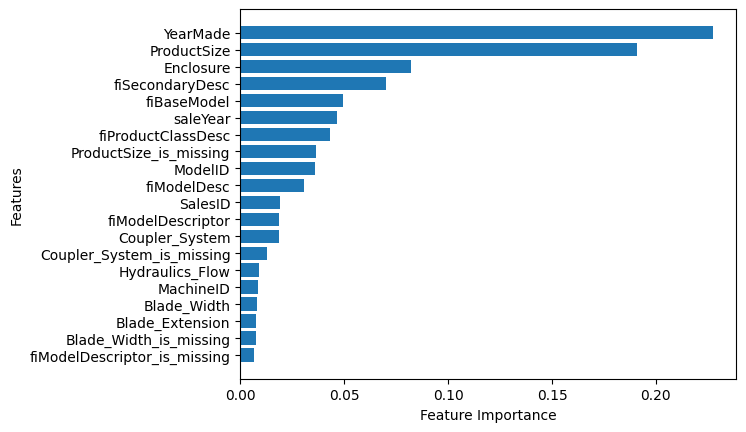

In [119]:
# Find feature importance of our best model
# Helper function for plotting feature importance
def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({"features": columns,
                        "feature_importances": importances})
          .sort_values("feature_importances", ascending=False)
          .reset_index(drop=True))
    # Plot the top n features
    fig, ax = plt.subplots()
    ax.barh(df["features"][:n], df["feature_importances"][:n])
    ax.set_ylabel("Features")
    ax.set_xlabel("Feature Importance")
    ax.invert_yaxis()

plot_features(X_train.columns, ideal_model.feature_importances_)

**Question:** Why might knowing the feature importance of our model be beneficial?
** Final challenge:** what other machine learning models could you try?
Hint: https://scikit-learn.org/stable/machine_learning_map.html